In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
import os
from keras.applications.resnet import preprocess_input
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
!gdown --id 1PFpjplIEQlJLQ-pwP-_0nlW657biWwbZ --output cats_dogs.zip

Downloading...
From: https://drive.google.com/uc?id=1PFpjplIEQlJLQ-pwP-_0nlW657biWwbZ
To: /content/cats_dogs.zip
852MB [00:14, 57.8MB/s]


In [3]:
!ls

cats_dogs.zip  sample_data


In [4]:
import zipfile
with zipfile.ZipFile('cats_dogs.zip') as z:
  z.extractall()

In [5]:
!ls

cats_dogs.zip  sample_data  sampleSubmission.csv  test1.zip  train.zip


In [6]:
with zipfile.ZipFile('train.zip') as z:
  z.extractall()
with zipfile.ZipFile('test1.zip') as z:
  z.extractall()

In [7]:
!ls

cats_dogs.zip  sampleSubmission.csv  test1.zip	train.zip
sample_data    test1		     train


In [8]:
!ls 'train'

cat.0.jpg      cat.3250.jpg  cat.7751.jpg   dog.12250.jpg  dog.5500.jpg
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.55

In [9]:
train_dir = 'train'
test_dir = 'test1'

In [10]:
def show_imgs(dir, n, k):
  filenames = os.listdir(dir)
  imgs = np.random.choice(filenames, size=n*k)
  plt.figure(figsize=(10, 10))
  for i in range(n*k):
    plt.subplot(n, k, i + 1)
    plt.imshow(image.load_img(dir + '/' + imgs[i]))

In [11]:
def dogs_cats_dataframe(dir):
  filenames = os.listdir(dir)
  df = pd.DataFrame({'filename':filenames})
  df['class'] = df['filename'].apply(lambda x:x[:3])
  return df

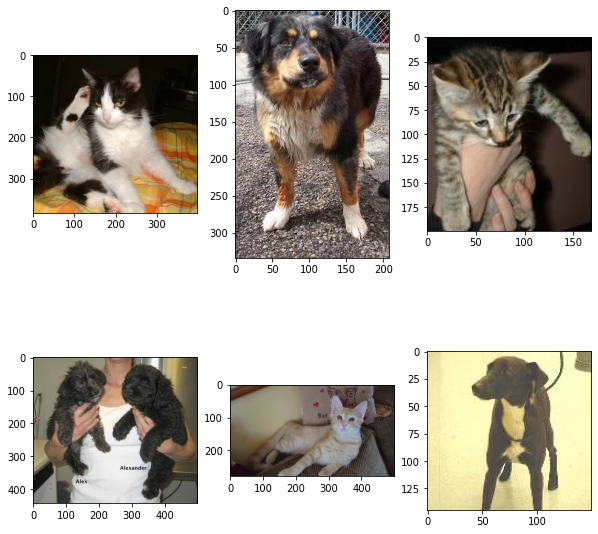

In [12]:
show_imgs(test_dir, 2, 3)

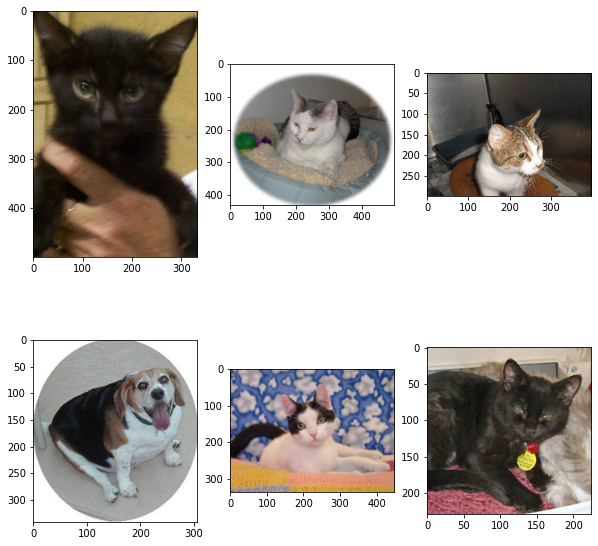

In [13]:
show_imgs(train_dir, 2, 3)

In [14]:
df_train = dogs_cats_dataframe(train_dir)

In [15]:
df_train

,filename,class
0,dog.6861.jpg,dog
1,dog.6803.jpg,dog
2,cat.2354.jpg,cat
3,dog.12009.jpg,dog
4,dog.4517.jpg,dog
...,...,...
24995,dog.10002.jpg,dog
24996,cat.1952.jpg,cat
24997,cat.2226.jpg,cat
24998,cat.8424.jpg,cat


In [16]:
train, val = train_test_split(df_train, test_size=0.2)
train_gen_aug = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                     height_shift_range=0.1,
                                     width_shift_range=0.1,
                                     zoom_range=0.2)
train_aug = train_gen_aug.flow_from_dataframe(train,
                                      train_dir,
                                      target_size=(224, 224),
                                      class_mode='categorical'
                                    )
val_gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
val_g = val_gen.flow_from_dataframe(val, 
                                    train_dir,
                                      target_size=(224, 224),
                                      class_mode='categorical'
                                    )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [17]:
resnet = keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))
resnet.trainable = False


resnet.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [18]:
model = keras.Sequential([
                    resnet,
                    keras.layers.Flatten(),
                    keras.layers.Dense(512, activation='relu'),
                    keras.layers.Dropout(0.4),
                    keras.layers.Dense(2, activation='softmax')
])


In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [20]:
lr = keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2)
mch = keras.callbacks.ModelCheckpoint('model.h5')

In [21]:
history = model.fit_generator(train_aug, epochs=15, validation_data=val_g, callbacks=[lr, mch])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
625/625 [==============================] - 390s 569ms/step - loss: 0.2085 - acc: 0.9683 - val_loss: 0.0467 - val_acc: 0.9852


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
625/625 [==============================] - 355s 568ms/step - loss: 0.0608 - acc: 0.9804 - val_loss: 0.0394 - val_acc: 0.9868
Epoch 3/15
625/625 [==============================] - 352s 562ms/step - loss: 0.0440 - acc: 0.9856 - val_loss: 0.0444 - val_acc: 0.9882
Epoch 4/15
625/625 [==============================] - 356s 569ms/step - loss: 0.0376 - acc: 0.9873 - val_loss: 0.0429 - val_acc: 0.9876
Epoch 5/15
625/625 [==============================] - 352s 562ms/step - loss: 0.0259 - acc: 0.9905 - val_loss: 0.0368 - val_acc: 0.9890
Epoch 6/15
625/625 [==============================] - 349s 559ms/step - loss: 0.0230 - acc: 0.9922 - val_loss: 0.0358 - val_acc: 0.9886
Epoch 7/15
625/625 [==============================] - 355s 568ms/step - loss: 0.0173 - acc: 0.9940 - val_loss: 0.0382 - val_acc: 0.9880
Epoch 8/15
625/625 [==============================] - 355s 568ms/step - loss: 0.0163 - acc: 0.9940 - val_loss: 0.0402 - val_acc: 0.9882
Epoch 9/15
625/625 [============================

In [22]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

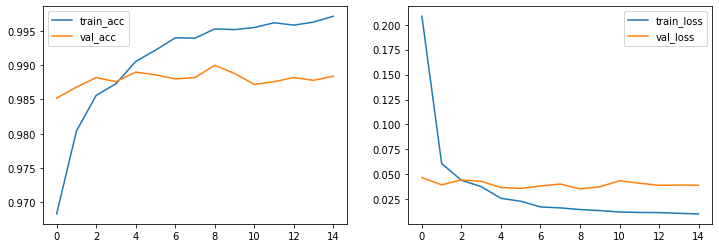

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()